In [44]:
import rasterio as rio
from PIL import Image
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

# Read image as NP array

In [43]:
png_path = "/home/chocobo/storage/ñuble_imgs/Allbands_18HYE_10m_0.00_0.20_step0.20.nc_chunk=0.png"
filename = png_path.split('/')[-1].replace('.png', '')
variables = filename.split('_')
tile = variables[1]
lat_percent = variables[3]
lon_percent = variables[4]
step = variables[5].replace('step', '')[:-3]
filename, tile, lat_percent, lon_percent, step

('Allbands_18HYE_10m_0.00_0.20_step0.20.nc_chunk=0',
 '18HYE',
 '0.00',
 '0.20',
 '0.20')

In [19]:
image = Image.open(png_path)
 
# Summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

PNG
(256, 256)
L


In [20]:
# This is the DataArray Variable
# The image is a mask, has 1 dimention
np_img = np.asarray(image)
np_img.shape

(256, 256)

# Get LatLon values

In [45]:
sentinel_tiles_path = '/home/chocobo/storage/Sentinel-2-Shapefile-Index/sentinel_2_index_shapefile.shp'
tiles_df = gpd.read_file(sentinel_tiles_path)
tiles_df.sample(3)

,Name,geometry
3574,04MEA,"POLYGON Z ((-159.00018 -3.61852 0.00000, -158...."
3045,03UYS,"POLYGON Z ((-162.12428 51.41590 0.00000, -160...."
339,01JCG,"POLYGON Z ((-179.06959 -29.81426 0.00000, -177..."


In [50]:
selected_tiles_df = tiles_df[ (tiles_df['Name'] == '18HYE') | (tiles_df['Name'] == '19HBV') ]
selected_tiles_df

,Name,geometry
16595,18HYE,"POLYGON Z ((-72.77806 -36.12374 0.00000, -71.5..."
17500,19HBV,"POLYGON Z ((-72.33238 -36.09798 0.00000, -71.1..."


<AxesSubplot:>

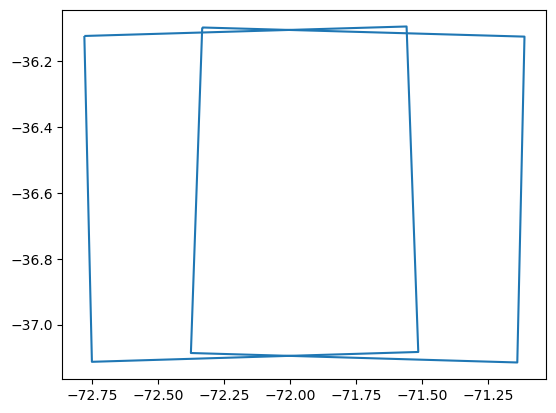

In [54]:
selected_tiles_df.boundary.plot()

<class 'shapely.geometry.polygon.Polygon'>


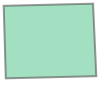

In [59]:
shape = selected_tiles_df.iloc[0].geometry
print(type(selected_tiles_df.iloc[0].geometry))
shape

In [60]:
from shapely import affinity
from shapely.geometry.multipolygon import MultiPolygon
from scipy.spatial import Voronoi

# Voronoi doesn't work properly with points below (0,0) so set lowest point to (0,0)
shape = affinity.translate(shape, -shape_a.bounds[0], -shape_a.bounds[1])

points = shape_to_points(shape)

vor = points_to_voronoi(points)

triangles = MultiPolygon(triangulate(MultiLineString(vor)))



def shape_to_points(shape, num = 10, smaller_versions = 10):
    points = []

    # Take the shape, shrink it by a factor (first iteration factor=1), and then 
    # take points around the contours
    for shrink_factor in range(0,smaller_versions,1):
        # calculate the shrinking factor
        shrink_factor = smaller_versions - shrink_factor
        shrink_factor = shrink_factor / float(smaller_versions)
        # actually shrink - first iteration it remains at 1:1
        smaller_shape = affinity.scale(shape, shrink_factor, shrink_factor)
        # Interpolate numbers around the boundary of the shape
        for i in range(0,int(num*shrink_factor),1):
            i = i / int(num*shrink_factor)
            x,y =  smaller_shape.interpolate(i, normalized=True).xy
            points.append( (x[0],y[0]))
    
    # add the origin
    x,y = smaller_shape.centroid.xy

NameError: name 'shape_a' is not defined

## Get subtile polygon

# Make mask into georeferenced XArray

In [34]:
lat = np.random.rand(np_img.shape[0], np_img.shape[1]) # latitude is the same size as the first axis
lon = np.random.rand(np_img.shape[0], np_img.shape[1]) # longitude is the same size as second axis
lat.shape, lon.shape

((256, 256), (256, 256))

In [36]:
ds = xr.Dataset(
    data_vars=dict(
        mask=(["x", "y"], np_img),
    ),
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
    ),
    attrs=dict(description="Georefrenced Mask from PNG"),
)
ds

<xarray.Dataset>
Dimensions:  (x: 256, y: 256)
Coordinates:
    lon      (x, y) float64 0.1829 0.2833 0.9397 ... 0.7006 0.5475 0.04855
    lat      (x, y) float64 0.1183 0.6399 0.1434 0.9447 ... 0.4328 0.4941 0.7627
Dimensions without coordinates: x, y
Data variables:
    mask     (x, y) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    description:  Georefrenced Mask from PNG

In [33]:
np.random.seed(0)
temperature = 15 + 8 * np.random.randn(2, 2, 3)
precipitation = 10 * np.random.rand(2, 2, 3)
lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]
time = pd.date_range("2014-09-06", periods=3)
reference_time = pd.Timestamp("2014-09-05")
temperature.shape, np.array(lon).shape

((2, 2, 3), (2, 2))

In [29]:
ds = xr.Dataset(
    data_vars=dict(
        temperature=(["x", "y", "time"], temperature),
        precipitation=(["x", "y", "time"], precipitation),
    ),
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
        time=time,
        reference_time=reference_time,
    ),
    attrs=dict(description="Weather related data."),
)
ds

<xarray.Dataset>
Dimensions:         (x: 2, y: 2, time: 3)
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y, time) float64 29.11 18.2 22.83 ... 18.28 16.15 26.63
    precipitation   (x, y, time) float64 5.68 9.256 0.7104 ... 7.992 4.615 7.805
Attributes:
    description:  Weather related data.